In [ ]:
!unzip titanic.zip

Archive:  titanic.zip
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.columns.isin(test.columns)

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [ ]:
y = train['Survived']
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [ ]:
X = train.drop('Survived', axis=1)
X.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Quis preencher as idades faltantes com a mediana de acordo com a classe da pessoa.

In [ ]:
# Calcular a mediana da idade para cada classe
median_age_by_class = train.groupby('Pclass')['Age'].median()

# Preencher os valores vazios na coluna 'Age' com a mediana da classe correspondente
train['Age'] = train.apply(lambda row: median_age_by_class[row['Pclass']] if pd.isnull(row['Age']) else row['Age'], axis=1)

# Verificar se ainda existem valores ausentes
print(train['Age'].isnull().sum())

0


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosDesejados(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasIndesejadas_ = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    return self
  def transform(self, X, y=None):
    return X.drop(self.colunasIndesejadas_, axis=1)

atributosDesejados = AtributosDesejados()
Xdrop = atributosDesejados.fit_transform(X)
Xdrop.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosNumericos(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasNumericas = X.select_dtypes(include='number').columns
    return self
  def transform(self, X, y=None):
    return X[self.colunasNumericas]

atributosNumericos = AtributosNumericos()
Xnum = atributosNumericos.fit_transform(Xdrop)
Xnum.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipenum = Pipeline([
    ('atributos_numericos', AtributosNumericos()),
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

XnumLimpo = pipenum.fit_transform(Xdrop)
XnumLimpo

array([[ 0.82737724, -0.56573646,  0.43279337, -0.47367361, -0.50244517],
       [-1.56610693,  0.66386103,  0.43279337, -0.47367361,  0.78684529],
       [ 0.82737724, -0.25833709, -0.4745452 , -0.47367361, -0.48885426],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337,  2.00893337, -0.17626324],
       [-1.56610693, -0.25833709, -0.4745452 , -0.47367361, -0.04438104],
       [ 0.82737724,  0.20276197, -0.4745452 , -0.47367361, -0.49237783]])

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosCategoricos(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasCategoricas = X.select_dtypes(include='object').columns
    return self
  def transform(self, X, y=None):
    return X[self.colunasCategoricas]

atributosCategoricos = AtributosCategoricos()
Xcat = atributosCategoricos.fit_transform(Xdrop)
Xcat.columns

Index(['Sex', 'Embarked'], dtype='object')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

pipecat = Pipeline([
    ('atributos_categoricos', AtributosCategoricos()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

XcatLimpo = pipecat.fit_transform(Xdrop)
XcatLimpo.toarray()

array([[0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0.]])

In [ ]:
from sklearn.pipeline import FeatureUnion

unecaracteristicas = FeatureUnion([
    ('pipenum', pipenum),
    ('pipecat', pipecat)
])

Xtratado = unecaracteristicas.fit_transform(Xdrop)
Xtratado.toarray()

array([[ 0.82737724, -0.56573646,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693,  0.66386103,  0.43279337, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724, -0.25833709, -0.4745452 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693, -0.25833709, -0.4745452 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724,  0.20276197, -0.4745452 , ...,  0.        ,
         1.        ,  0.        ]])

In [121]:
from sklearn.pipeline import Pipeline

preproc = Pipeline([
    ('atributos_desejados', AtributosDesejados()),
    ('unecaracteristicas', unecaracteristicas)
])

Xtratado = preproc.fit_transform(X)
Xtratado.toarray()

array([[ 0.82737724, -0.56573646,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693,  0.66386103,  0.43279337, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724, -0.25833709, -0.4745452 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693, -0.25833709, -0.4745452 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724,  0.20276197, -0.4745452 , ...,  0.        ,
         1.        ,  0.        ]])

In [122]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

pipetotal = Pipeline([
    ('preproc', preproc),
    ('arvore', DecisionTreeClassifier())
])

pipetotal.fit(X, y)
ypred = pipetotal.predict(X)
accuracy_score(y, ypred)

0.9797979797979798

In [123]:
import numpy as np
from sklearn.model_selection import cross_validate

scores = cross_validate(pipetotal, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([0.02209973, 0.01650786, 0.01632166, 0.0159595 , 0.0165534 ]),
  'score_time': array([0.00670695, 0.00719237, 0.00679135, 0.00686884, 0.00675058]),
  'test_score': array([0.74860335, 0.78651685, 0.80337079, 0.73595506, 0.80337079])},
 0.775563367020275)

In [125]:
from sklearn.model_selection import GridSearchCV

parametros = {
    'arvore__max_depth': [None, 1, 3, 5, 7, 9],
    'preproc__unecaracteristicas__pipenum__imputer__strategy': ['mean', 'median', 'most_frequent']
}

modelo = GridSearchCV(pipetotal, param_grid=parametros)

scores = cross_validate(modelo, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([3.68666601, 3.73877144, 2.85586619, 2.37374592, 2.16986156]),
  'score_time': array([0.03239751, 0.00749373, 0.00945568, 0.00662017, 0.00661111]),
  'test_score': array([0.81564246, 0.81460674, 0.81460674, 0.78089888, 0.85393258])},
 0.8159374803841567)

In [ ]:
modelo.fit(X, y)
modelo.best_estimator_

In [ ]:
submission = pd.read_csv('gender_submission.csv')
ypred = modelo.predict(test)
submission['Survived'] = ypred
submission.to_csv('tree_gscv_submission.csv', index=False)

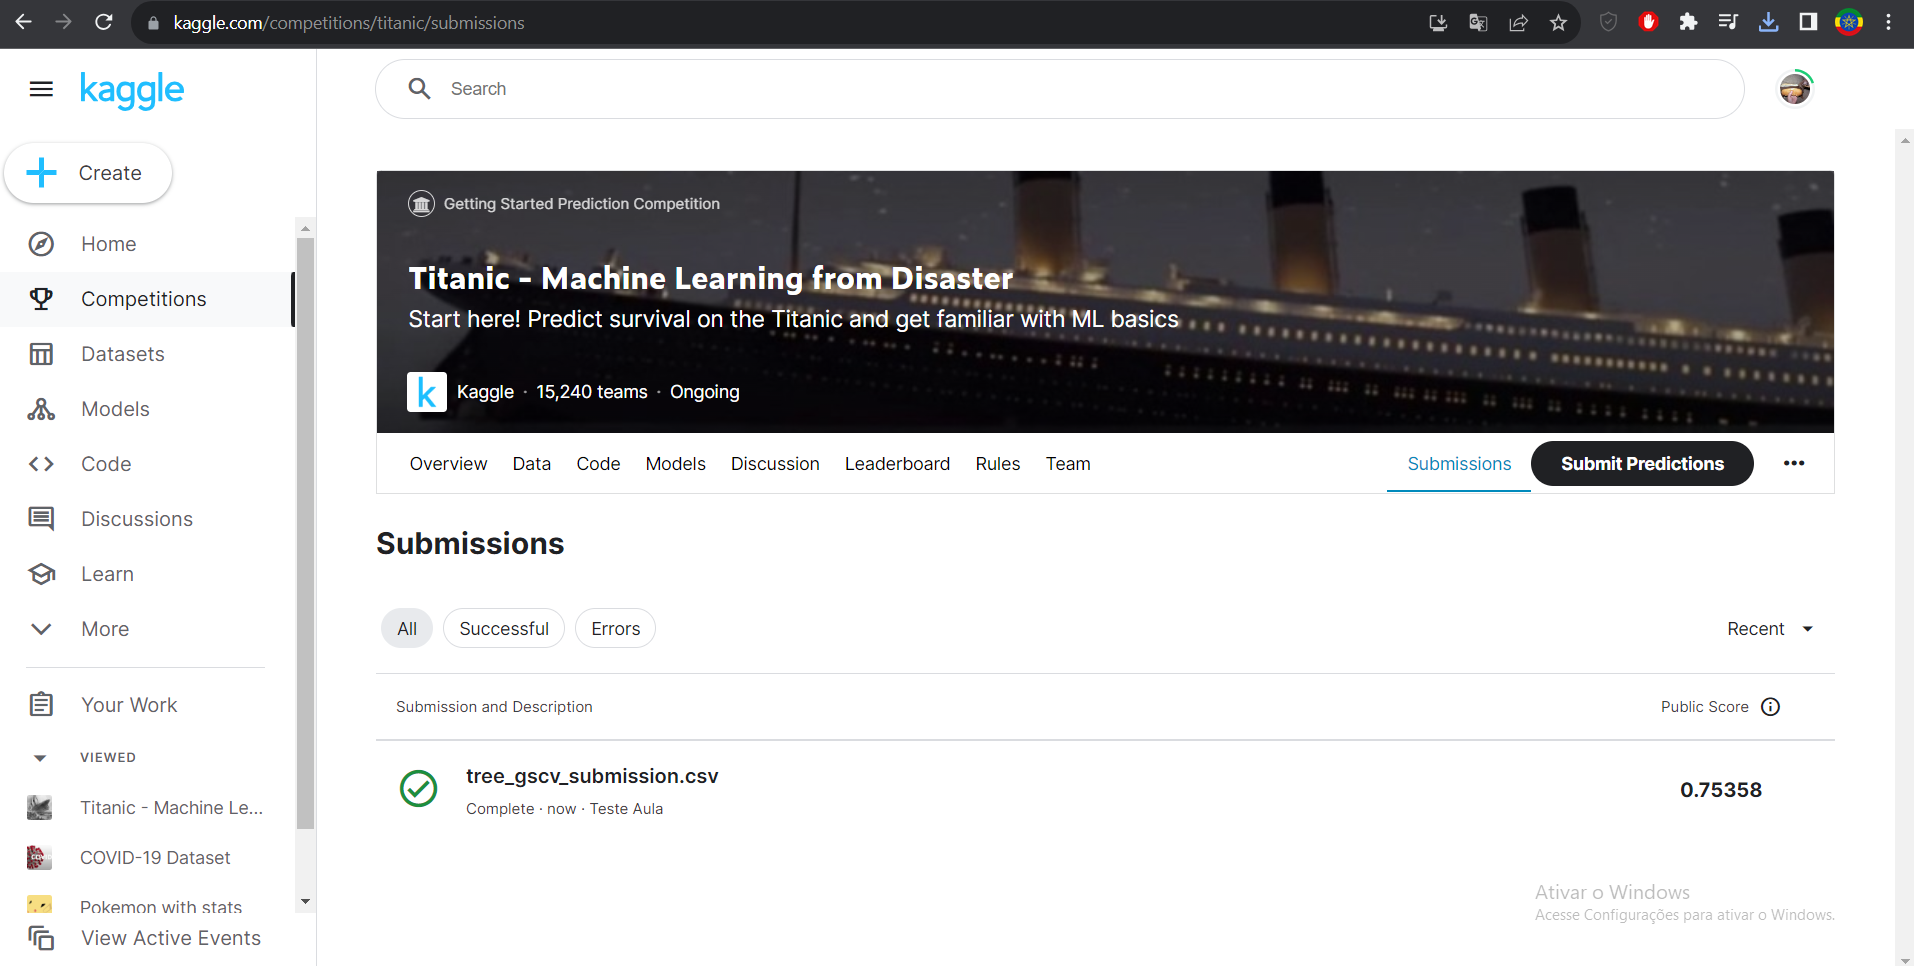